In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchvision
import numpy as np
from numpy.linalg import inv
from numpy.linalg import solve
import scipy.spatial.distance as dist
from sklearn.decomposition import PCA #importing pca from sklearn

In [27]:
n1 = 100
kfolds = 5

In [28]:
np.floor(np.arange(0, n1, 1) * kfolds / n1) + 1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [39]:
def Gauss(x, c_l, sigma):
  phi_l_x = np.exp((-0.5 * (np.linalg.norm(x - c_l))**2)/(sigma**2))
  return phi_l_x

def GaussBasis(X, C, sigma):
  phi = []
  for i in tqdm(range(len(C))):
    c_l = C[i]
    temp = []
    for x in X:
      temp.append(Gauss(x, c_l, sigma))
    phi.append(temp)
  return phi

def CalculateDist2(X, Y):
  # calculate squared distance using cdist
  sq_dist = dist.cdist(X.T, Y.T, metric='sqeuclidean')
  med_dist = np.sqrt(np.median(sq_dist))
  return sq_dist, med_dist

def accu(L1, L2):
  sum = 0
  for i in range(len(L1)):
    if L1[i]==L2[i]:
      sum += 1
  return (sum/len(L1))*100

def y_test_shuff(xm, xp):
  y_test = [-1 for i in range(len(xm))]
  for k in range(len(xp)):
    l = np.random.randint(len(xm))
    p = np.random.randint(len(xp))
    xm.insert(l, xp[p])
    y_test.insert(l, 1)
    del xp[p]
  return xm, y_test


def PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds):
  n1 = np.shape(xp)[0] #no. of positive labeled samples
  n2 = np.shape(xm)[0] #no. of unlabeled samples

  #split the data into training and test folds
  cv_split_xp = np.floor(np.arange(0, n1, 1) * kfolds / n1) + 1 
  cv_split_xm = np.floor(np.arange(0, n2, 1) * kfolds / n2) + 1

  ind = []

  for k in range(1, kfolds+1):
    ind.append([np.where(cv_split_xp != k)[0][0], np.where(cv_split_xp != k)[0][-1], np.where(cv_split_xp == k)[0][0], np.where(cv_split_xp == k)[0][-1], np.where(cv_split_xm != k)[0][0], np.where(cv_split_xm != k)[0][-1], np.where(cv_split_xm == k)[0][0], np.where(cv_split_xm == k)[0][-1] ])

  del cv_split_xp
  del cv_split_xm

  #cv_scores = np.zeros((len(sigma_list), len(lambda_list)))

  #alphas = []

  fold_data = []

  for k in range(0, kfolds):

    cv_scores = np.zeros((len(sigma_list), len(lambda_list)))

    print("----------------------------------")
    print('K = ', k+1)
    print("----------------------------------")

    '''01
       23
       45
       67'''

    #get the training and test datasets
    idx_xp_tr = [ind[k][0], ind[k][1]]
    idx_xp_te = [ind[k][2], ind[k][3]]

    idx_xm_tr = [ind[k][4], ind[k][5]]
    idx_xm_te = [ind[k][6], ind[k][7]]
    

    xp_tr = xp[idx_xp_tr[0] : idx_xp_tr[-1], :]
    xp_te = xp[idx_xp_te[0] : idx_xp_te[-1], :]

    xm_tr = xm[idx_xm_tr[0] : idx_xm_tr[-1], :]
    xm_te = xm[idx_xm_te[0] : idx_xm_te[-1], :]

    #set the basis functions (numerator without test samples)

    x_ce = xp_tr
    b = np.array(x_ce).shape[0]

    #Test data
    x_test, y_test = y_test_shuff(xm_te.tolist(), xp_te.tolist())
    x_test = np.array(x_test)

    for sigma_idx in tqdm(range(len(sigma_list))):


      sigma = sigma_list[sigma_idx]
      print('sigma = ', sigma)

      #Calculate the Phi matrices
      Phi1_tr = GaussBasis(xp_tr, x_ce, sigma)
      Phi2_tr = GaussBasis(xm_tr, x_ce, sigma)

      for lmbda_idx in range(len(lambda_list)):
        lmbda = lambda_list[lmbda_idx]
        print('lambda = ', lmbda)

        #Calculating the functional value
        score = 0
        for l in range(b):
          beta__l = ( np.mean(Phi2_tr[l]) ) - ( np.mean(Phi1_tr[l]) )
          #sum = sum + beta__l * max(0, beta__l)
          alpha__l =  ( max(0 , beta__l) )/lmbda
          score += ((lmbda*alpha__l**2) / 2) - (alpha__l*beta__l)
        
        cv_scores[sigma_idx][lmbda_idx] = score

      del Phi1_tr
      del Phi2_tr

    idxp = np.where(cv_scores == np.min(cv_scores))[0][0]
    idxm = np.where(cv_scores == np.min(cv_scores))[1][0]

    del cv_scores

    sigma_chosen = sigma_list[idxp]
    lambda_chosen = lambda_list[idxm]

    #setup the basis functions and calculate Phi, h, and H
    x_ce = xp #+ xm.tolist()
    b = x_ce.shape[0]

    Phi1 = GaussBasis(xp, x_ce, sigma_chosen)
    Phi2 = GaussBasis(xm, x_ce, sigma_chosen)

    num = 1+ ((2/(n1*n2*lambda_chosen))*np.sum([np.sum([Phi1[i]])*np.sum([Phi2[i]]) for i in range(b)]))*lambda_chosen*(n2**2)
    den = 2*np.sum([(np.sum([Phi2[i] for i in range(b)]))**2])


    prior = num/den

    prior = max(prior, n1/(n1+n2))
    prior = min(prior, 1)

    alpha_lst = []


    for l in range(b):
      beta_l = (np.mean(Phi2[l]) ) - (np.mean(Phi1[l]))
      alpha_l =  ( max(0 , beta_l) )/lambda_chosen

      #print('phi2 =', np.mean(Phi2[l]), 'phi1 =', np.mean(Phi1[l]),'beta=', beta_l,'alpha=', alpha_l )

      alpha_lst.append(alpha_l)

    del Phi1
    del Phi2

    
    #estimating r(x)
    
    prediction_set = []
    for x in x_test:
      phi_l_x_i =  [Gauss(x, x_l, sigma_chosen) for x_l in x_ce]
      r_xi_hat = np.dot(np.array(alpha_lst), np.array(phi_l_x_i)) - 1

      #print(r_xi_hat)

      #Prediction part
      if (prior*r_xi_hat) >= 0.5 :
        y_pred = 1
      else:
        y_pred = -1
      prediction_set.append(y_pred)
    
    del phi_l_x_i
    del r_xi_hat

    print('Prior - ', prior, '|| Accu -', accu(prediction_set, y_test), '|| Sigma -', sigma_chosen, '|| Lambda -', lambda_chosen) 
    fold_data.append([prior, accu(prediction_set, y_test)])

    del prediction_set

  return fold_data

In [3]:
train_data = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
X_train_npa = [x.numpy() for x,_ in train_data]
y_train_npa = [y for _,y in train_data]

test_data = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
X_test_npa = [x.numpy() for x,_ in test_data]
y_test_npa = [y for _,y in test_data]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
len(X_train_npa), len(y_train_npa), len(X_test_npa), len(y_test_npa)

(60000, 60000, 10000, 10000)

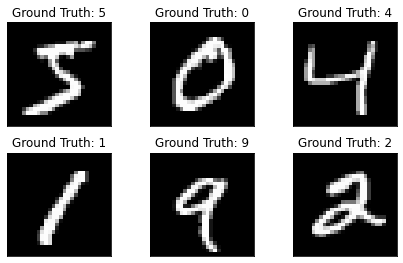

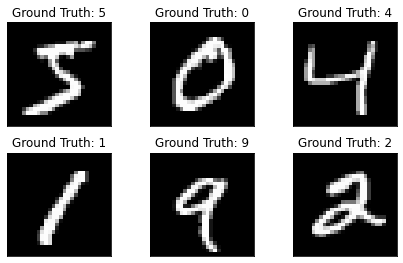

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train_npa[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(y_train_npa[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.array(y_train_npa) !=1).nonzero()[0]]

#del X_train_npa
#del y_train_npa
#del X_test_npa
#del y_test_npa

In [7]:
xpp.shape

(6742, 1, 28, 28)

In [8]:
xmm.shape

(53258, 1, 28, 28)

#Experiment 1 - 0.2

In [15]:
xp = xpp[1000:2300,0,:,:]
xm = xmm[22000:25700,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

for i in range(300):
  xm_.append(xp_[i])
  del xp_[i]
  np.random.shuffle(xp_)


xp = np.array(xp_)
xm = np.array(xm_)

##########################
pca = PCA(n_components= 4) #creating an object for PCA with components 4
xp = pca.fit_transform(xp) #fitting and transforming the data

pca = PCA(n_components = 4)  #creating an object for PCA with components 4
xm = pca.fit_transform(xm)  #fitting and transforming the data

np.random.shuffle(xp)
np.random.shuffle(xm)

In [16]:
xp.shape

(1000, 4)

In [17]:
xm.shape

(4000, 4)

In [18]:
lambda_list= np.logspace(-3,1,5)
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5, 5)*med_dist
kfolds = 2

In [19]:
del xpp
del xmm
del xp_
del xm_

In [20]:
print(lambda_list)
print(sigma_list)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
[ 1.20476081  8.4333257  15.66189059 22.89045548 30.11902037]


In [23]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

----------------------------------
K =  1
----------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  8.433325704744904


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  15.66189059452625


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  22.890455484307594


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  30.119020374088944


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Prior -  0.2 || Accu - 20.536429143314653 || Sigma - 8.433325704744904 || Lambda - 0.001
----------------------------------
K =  2
----------------------------------


IndexError: ignored

#Experiment 2 - 0.4

In [27]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.array(y_train_npa) !=1).nonzero()[0]]

In [28]:
xp = xpp[1000:3400,0,:,:]
xm = xmm[22000:24600,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

for i in range(400):
  xm_.append(xp_[i])
  del xp_[i]
  np.random.shuffle(xp_)


xp = np.array(xp_)
xm = np.array(xm_)

##########################
pca = PCA(n_components= 4) #creating an object for PCA with components 4
xp = pca.fit_transform(xp) #fitting and transforming the data

pca = PCA(n_components = 4)  #creating an object for PCA with components 4
xm = pca.fit_transform(xm)  #fitting and transforming the data

np.random.shuffle(xp)
np.random.shuffle(xm)

In [29]:
xp.shape

(2000, 4)

In [30]:
xm.shape

(3000, 4)

In [31]:
lambda_list= np.logspace(-3,1,5)
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5, 5)*med_dist
kfolds = 2

In [32]:
del xpp
del xmm
del xp_
del xm_

In [33]:
print(lambda_list)
print(sigma_list)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
[ 1.20476081  8.4333257  15.66189059 22.89045548 30.11902037]


In [34]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

----------------------------------
K =  1
----------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  8.433325704744904


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  15.66189059452625


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  22.890455484307594


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  30.119020374088944


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Prior -  0.4 || Accu - 39.9919935948759 || Sigma - 8.433325704744904 || Lambda - 0.001
----------------------------------
K =  2
----------------------------------


IndexError: ignored

#Experiment 3 - 0.6

In [39]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.array(y_train_npa) !=1).nonzero()[0]]

In [40]:
xp = xpp[1000:4500,0,:,:]
xm = xmm[22000:23500,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

for i in range(500):
  xm_.append(xp_[i])
  del xp_[i]
  np.random.shuffle(xp_)


xp = np.array(xp_)
xm = np.array(xm_)

##########################
pca = PCA(n_components= 4) #creating an object for PCA with components 4
xp = pca.fit_transform(xp) #fitting and transforming the data

pca = PCA(n_components = 4)  #creating an object for PCA with components 4
xm = pca.fit_transform(xm)  #fitting and transforming the data

np.random.shuffle(xp)
np.random.shuffle(xm)

In [41]:
xp.shape

(3000, 4)

In [42]:
xm.shape

(2000, 4)

In [43]:
lambda_list= np.logspace(-3,1,5)
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5, 5)*med_dist
kfolds = 2

In [44]:
del xpp
del xmm
del xp_
del xm_

In [45]:
print(lambda_list)
print(sigma_list)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
[ 1.20476081  8.4333257  15.66189059 22.89045548 30.11902037]


In [46]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

----------------------------------
K =  1
----------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  8.433325704744904


  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  15.66189059452625


  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  22.890455484307594


  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  30.119020374088944


  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Prior -  0.6 || Accu - 60.12810248198559 || Sigma - 8.433325704744904 || Lambda - 0.001
----------------------------------
K =  2
----------------------------------


IndexError: ignored

#Experiment 4 - 0.8

In [62]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.array(y_train_npa) !=1).nonzero()[0]]

In [63]:
xp = xpp[1000:5600,0,:,:]
xm = xmm[22000:22400,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

for i in range(600):
  xm_.append(xp_[i])
  del xp_[i]
  np.random.shuffle(xp_)


xp = np.array(xp_)
xm = np.array(xm_)

##########################
pca = PCA(n_components= 4) #creating an object for PCA with components 4
xp = pca.fit_transform(xp) #fitting and transforming the data

pca = PCA(n_components = 4)  #creating an object for PCA with components 4
xm = pca.fit_transform(xm)  #fitting and transforming the data

np.random.shuffle(xp)
np.random.shuffle(xm)

In [64]:
xp.shape

(4000, 4)

In [65]:
xm.shape

(1000, 4)

In [66]:
lambda_list= np.logspace(-3,1,5)
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5, 5)*med_dist
kfolds = 2

In [67]:
del xpp
del xmm
del xp_
del xm_

In [68]:
print(lambda_list)
print(sigma_list)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
[ 1.20476081  8.4333257  15.66189059 22.89045548 30.11902037]


In [69]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

----------------------------------
K =  1
----------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  8.433325704744904


  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  15.66189059452625


  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  22.890455484307594


  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0
sigma =  30.119020374088944


  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

lambda =  0.001
lambda =  0.01
lambda =  0.1
lambda =  1.0
lambda =  10.0


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Prior -  0.8 || Accu - 80.0240192153723 || Sigma - 8.433325704744904 || Lambda - 0.001
----------------------------------
K =  2
----------------------------------


IndexError: ignored